In [53]:
import trackhhl.toy.simple_generator as toy
import trackhhl.event_model.q_event_model as em
import numpy as np
import itertools
import copy
import time
import cProfile
import scipy


### Detector Geometry

In [54]:
N_MODULES = 5
LX = float("+inf")
LY = float("+inf")
Z_SPACING = 1.0

detector = toy.SimpleDetectorGeometry(
    module_id=list(range(N_MODULES)),
    lx=[LX]*N_MODULES,
    ly=[LY]*N_MODULES,
    z=[i+Z_SPACING for i in range(N_MODULES)]
)

detector

SimpleDetectorGeometry(module_id=[0, 1, 2, 3, 4], lx=[inf, inf, inf, inf, inf], ly=[inf, inf, inf, inf, inf], z=[1.0, 2.0, 3.0, 4.0, 5.0])

### Particle Generator


In [55]:
generator = toy.SimpleGenerator(
    detector_geometry=detector,
    theta_max=np.pi/6
)
generator

SimpleGenerator(detector_geometry=SimpleDetectorGeometry(module_id=[0, 1, 2, 3, 4], lx=[inf, inf, inf, inf, inf], ly=[inf, inf, inf, inf, inf], z=[1.0, 2.0, 3.0, 4.0, 5.0]), primary_vertices=[], phi_min=0.0, phi_max=6.283185307179586, theta_min=0.0, theta_max=0.5235987755982988, rng=Generator(PCG64) at 0x20FD0D134C0)

In [56]:
N_PARTICLES = 200
event = generator.generate_event(N_PARTICLES)
event.hits

[Hit(hit_id=0, x=-0.18108877260067707, y=-0.014004053380174656, z=1.0, module_id=0, track_id=0),
 Hit(hit_id=5, x=-0.21197897427406778, y=-0.20594613554935282, z=1.0, module_id=0, track_id=1),
 Hit(hit_id=10, x=0.1550873833602122, y=-0.10884225432662599, z=1.0, module_id=0, track_id=2),
 Hit(hit_id=15, x=0.45920109739044945, y=0.2501895107166791, z=1.0, module_id=0, track_id=3),
 Hit(hit_id=20, x=-0.21212105750831498, y=0.04000599637329127, z=1.0, module_id=0, track_id=4),
 Hit(hit_id=25, x=0.03756199866903663, y=-0.09283770731075752, z=1.0, module_id=0, track_id=5),
 Hit(hit_id=30, x=0.22895768962898932, y=0.187211176216028, z=1.0, module_id=0, track_id=6),
 Hit(hit_id=35, x=0.28162717795474546, y=0.2535913453486401, z=1.0, module_id=0, track_id=7),
 Hit(hit_id=40, x=-0.014816559679968602, y=-0.038072035151732284, z=1.0, module_id=0, track_id=8),
 Hit(hit_id=45, x=-0.24879982630390896, y=0.4278973832174889, z=1.0, module_id=0, track_id=9),
 Hit(hit_id=50, x=0.1206905700304344, y=-0.31

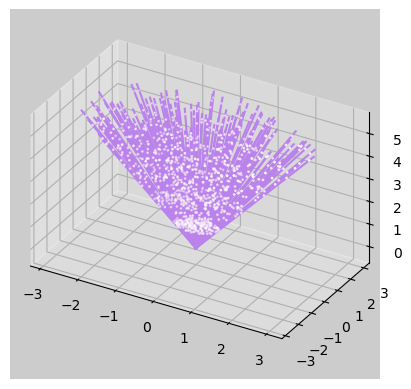

In [57]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
event.display(ax)
plt.show()

In [58]:
import psutil
from scipy.sparse import lil_matrix

process = psutil.Process()
profiler = cProfile.Profile()
profiler.enable() 
start_time = time.time()
mem_ham1= process.memory_info().rss / (1024 ** 2)

def generate_hamiltonian(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    # Use shallow copy 
    modules = copy.copy(event.modules)
    modules.sort(key=lambda a: a.z)

    # Use a generator 
    segments = (
        em.segment(from_hit, to_hit)
        for idx in range(len(modules) - 1)
        for from_hit in modules[idx].hits
        for to_hit in modules[idx + 1].hits
    )
    segment_vectors = (seg.to_vect() for seg in segments)

    N = sum(1 for _ in segment_vectors) 
    A_ang = lil_matrix((N, N), dtype=np.float32) 
    A_bif = lil_matrix((N, N), dtype=np.float32)
    A_inh = lil_matrix((N, N), dtype=np.float32)

    #generator expression
    s_ab = (
        int(seg_i.from_hit.module_id == 1 and seg_j.to_hit.module_id == 1)
        for seg_i, seg_j in itertools.product(segments, repeat=2)
    )


    norm_cache = {}
    def get_vector_and_norm(seg, idx):
        if idx not in norm_cache:
            vect = seg.to_vect()
            norm_cache[idx] = (vect, np.linalg.norm(vect))
        return norm_cache[idx]

    for i, seg_i in enumerate(segments):
        vect_i, norm_i = get_vector_and_norm(seg_i, i)

        for j in range(i + 1, N):
            seg_j = segments[j]
            vect_j, norm_j = get_vector_and_norm(seg_j, j)

            cosine = np.dot(vect_i, vect_j) / (norm_i * norm_j)

            eps = 1e-9
            if np.abs(cosine - 1) < eps:
                A_ang[i, j] = A_ang[j, i] = 1

            if (seg_i.from_hit == seg_j.from_hit) and (seg_i.to_hit != seg_j.to_hit):
                A_bif[i, j] = A_bif[j, i] = -alpha

            if (seg_i.from_hit != seg_j.from_hit) and (seg_i.to_hit == seg_j.to_hit):
                A_bif[i, j] = A_bif[j, i] = -alpha

            A_inh[i, j] = A_inh[j, i] = s_ab[i * N + j] * s_ab[j * N + i] * beta

    A = -1 * (A_ang + A_bif + A_inh).tocsc() 
    b = np.zeros(N, dtype=np.float32)

    components = {
        'A_ang': -A_ang,
        'A_bif': -A_bif,
        'A_inh': -A_inh,
    }

    return A, b, components, segments
params = {
    'alpha': 1.0,
    'beta': 1.0,
    'lambda': 100.0,} 

A, b, _, _ = generate_hamiltonian(event, params)

finish_time = time.time()
mem_ham2= process.memory_info().rss / (1024 ** 2)
profiler.disable()  
profiler.print_stats()

print(A)
print(f'{finish_time - start_time}s')
print(f'{(mem_ham2-mem_ham1):.6f}gb')


         1121935 function calls (1121933 primitive calls) in 2.096 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 2302494705.py:1(<module>)
        1    0.000    0.000    2.095    2.095 2302494705.py:10(generate_hamiltonian)
        5    0.000    0.000    0.000    0.000 2302494705.py:17(<lambda>)
   160001    0.173    0.000    0.527    0.000 2302494705.py:20(<genexpr>)
   160001    0.153    0.000    1.100    0.000 2302494705.py:26(<genexpr>)
   160001    0.091    0.000    1.190    0.000 2302494705.py:28(<genexpr>)
        1    0.000    0.000    0.000    0.000 2302494705.py:34(<genexpr>)
        2    0.000    0.000    0.000    0.000 <frozen abc>:117(__instancecheck__)
       50    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:405(parent)
        2    0.000    0.000    0.000    0.000 <string>:1(<lambda>)
   160000    0.209    0.000    0.354    0.000 <string>:2(__

In [59]:
from dwave.samplers import SimulatedAnnealingSampler
import dimod
import dimod.binary



In [60]:
from scipy.sparse import csr_matrix
process = psutil.Process()
start_time = time.time()

initial_memory = process.memory_info().rss / (1024 ** 2)

matrix_A = csr_matrix(A)  # Efficient sparse matrix for memory savings

bqm = dimod.BinaryQuadraticModel({}, {}, 0.0, dimod.BINARY)

for i in range(len(b)):
    bqm.add_variable(i, b[i])

for i, j in zip(*matrix_A.nonzero()):
    bqm.add_interaction(i, j, matrix_A[i, j])

q, offset = bqm.to_qubo()

sampler = SimulatedAnnealingSampler()
response = sampler.sample_qubo(q, num_reads=100)

best_sample = response.first.sample
sol_sample = np.fromiter(best_sample.values(), dtype=int)  # Efficient conversion to numpy array

end_time = time.time()
final_memory = process.memory_info().rss / (1024 ** 2)
print(sol_sample)
print(f'Execution time: {end_time - start_time:.6f} seconds')
print(f'Memory usage: {final_memory - initial_memory:.6f} MB')


[1 1 0 ... 1 0 0]
Execution time: 55.555360 seconds
Memory usage: -281.777344 MB
